In [1]:
import sys
sys.path.append("/Users/anuram/Documents/hydrogenase-ftir/src")
sys.path.append("/Users/anuram/Documents/hydrogenase-ftir/notebooks/anu_winter_2024")

In [2]:
%load_ext autoreload
%autoreload 2

#Setting Up and Importing the Necessary Packages/Libraries
##Package for reading in Bruker OPUS type files
from brukeropusreader import read_file
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import pathlib
import numpy as np
import pandas as pd
#Local Functions
from hydrogenase_processing.cut_range import cut_range_subtraction
from hydrogenase_processing.second_deriv import second_deriv, first_deriv
#testing
#find peaks
from scipy.signal import find_peaks, peak_widths
from anchor_points import get_peaks, get_start_end_anchorpoints, get_all_anchor_points

In [3]:
#Paths to Local Data
path_to_water_vapor_data = pathlib.Path("../../../data/opus_files/water_vapor")
path_to_output_plots_= pathlib.Path("../../../data/output_plots/")
path_to_all_test_data = pathlib.Path("../../../data/opus_files/subtraction_coefficient_testing") 

## Importing the Data form the local paths specified above ##

In [4]:
#Importing Water Vapor
wv_data = read_file(f'{path_to_water_vapor_data}''/water vapor 4cm-1.1')

In [5]:
#Pulling in all test data
second_derivative_test_raw_data = list(path_to_all_test_data.iterdir())
second_derivative_test_raw_data.sort()

#Initializing dict of raw spectra files from the file system
raw_data = dict()

#Populating the raw_test_data dict with all the read in raw opus files
for i in (second_derivative_test_raw_data):
    if not i.name.startswith('.DS_Store'):
        raw_data[i.name[0:4]] = read_file(i)

print(raw_data.keys())

dict_keys(['007_', '009_', '010_', '011_', '011a', '011b', '011c', '011d', '011e', '011f', '011g', '011h', '011i', '011k', '011l', '011m', '011n', '011o', '011p', '011q', '011r', '011s', '011t', '012_', '013_', '015_', '016_', '020_', '024_', '028_', '032_', '035_', '160 ', '162 ', '164 ', '165 ', '166 ', '167 ', '168 ', '169 ', '170 ', '171 ', '172 ', '173 ', '174 ', '175 ', '176 '])


In [6]:
test_comparisons_parameters_df = pd.read_excel("../../../data/test_subtraction_coefficients.xlsx", sheet_name="uncut_samples")

#full_file_names = test_comparisons_parameters_df["file_name"]

test_comparisons_parameters_df["file_name"] = test_comparisons_parameters_df["file_name"].apply(lambda file_name: file_name[0:4]) 

#test_comparisons_parameters_df["file_name"] = exp_num_file_name


indexed_test_comparison_parameters = test_comparisons_parameters_df.set_index('file_name')


## Subtracting Water Vapor


In [7]:
#Initializing dict of post water vapor subtraction spectra
cut_range_sub_wv_data = dict()

results = list()

for idx, row in indexed_test_comparison_parameters.iterrows():  
    if idx in raw_data:
        raw_data_i = raw_data[idx]
        cut_range_sub_wv_data[f'{idx}_cut_range_wv_sub'] = cut_range_subtraction(raw_data_i, wv_data, row["range_start"], row["range_end"], SG_poly = 3, SG_points = 21)
        subtraction_parameters = cut_range_sub_wv_data[f'{idx}_cut_range_wv_sub'][0][0].fit_atm_params
        results.append(subtraction_parameters[0])
    else:
        results.append(None)

indexed_test_comparison_parameters["pb_subtraction_coefficient"] = results

2150 1800
959 1141
2150 1800
959 1141
2150 1800
959 1141
2150 1800
959 1141
2150 1850
959 1115
2150 1850
959 1115
2150 1850
959 1115
2150 1850
959 1115
2150 1850
959 1115
2150 1850
959 1115
2150 1850
959 1115
2150 1850
959 1115
2150 1850
959 1115
2150 1850
959 1115
2150 1850
959 1115
2150 1850
959 1115
2000 1800
1037 1141
2000 1800
1037 1141
2000 1800
1037 1141
2000 1800
1037 1141
2000 1800
1037 1141
2000 1800
1037 1141
2000 1800
1037 1141
2000 1800
1037 1141
2000 1800
1037 1141
2000 1800
1037 1141
2000 1800
1037 1141
2000 1800
1037 1141
2000 1800
1037 1141
2000 1800
1037 1141
2150 1850
959 1115
2150 1850
959 1115
2150 1850
959 1115
2150 1850
959 1115


# Get Second derivative


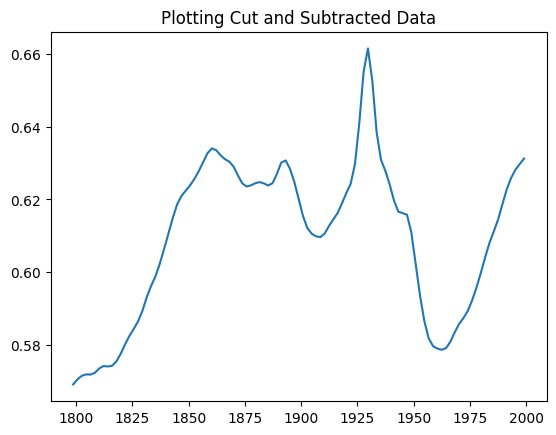

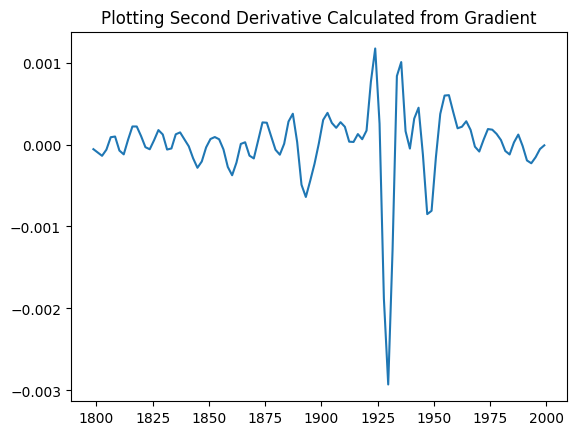

In [10]:
#Extracting wavenb and abs for one of the corrected spectra
example_cut_sub = cut_range_sub_wv_data["171 _cut_range_wv_sub"]

x = second_deriv(example_cut_sub, show_plots=True)


# Get Peaks


In [11]:
#because we want the peaks in the negative-y direction
d2ydx2_spl_upsidedown = x[1] * -1

#to determine what is the appropriate prominance parameter to use for different data
#attemptive method: calculate the peak height difference between each data points and take the average of the biggest 10 height difference results for the prominance parameter in find_peaks(), which gives a rough estimates of the signal scale

#function using for loop to subtract each data point with the next peak
peak_height_diff = []
for i in range(len(d2ydx2_spl_upsidedown)-1):    
    diff = d2ydx2_spl_upsidedown[i+1] - d2ydx2_spl_upsidedown[i]
    peak_height_diff.append(diff)

#sort the result list such that the peak height differences are listed from lowest to heighest
peak_height_diff.sort()

#average of top 10 data point height difference
#mean_diff = np.mean(peak_height_diff[len(peak_height_diff)-10:len(peak_height_diff)])

## Testing with the smaller peak width algorithm and tuning the ajustment factor

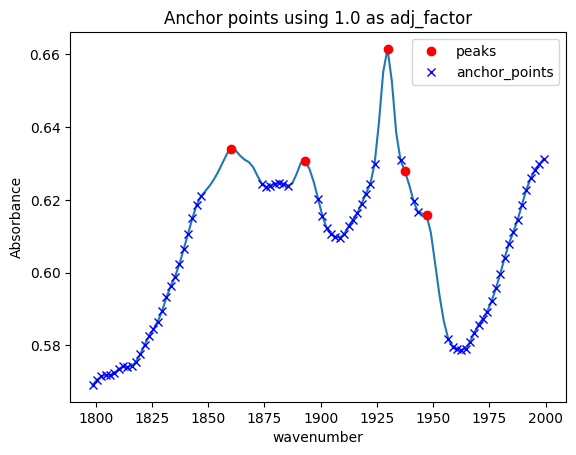

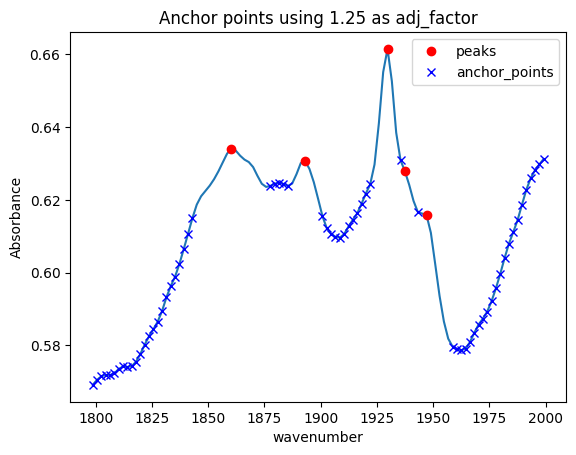

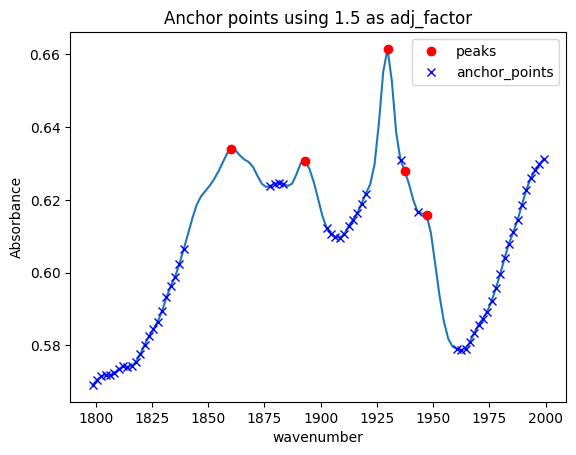

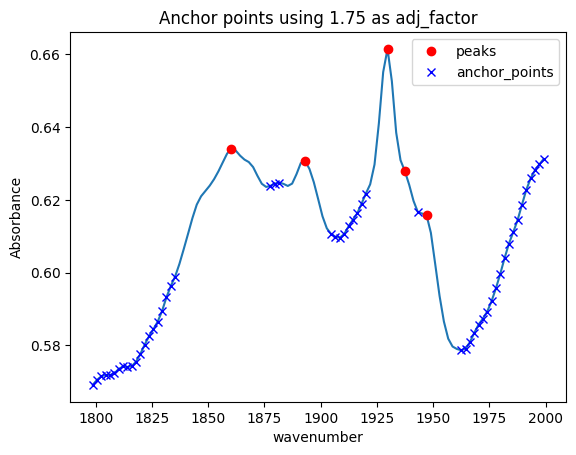

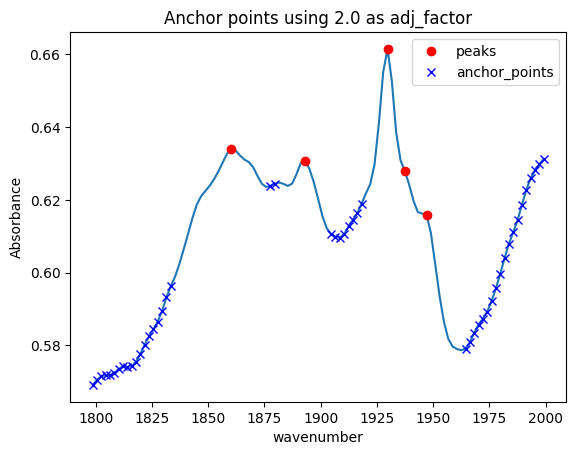

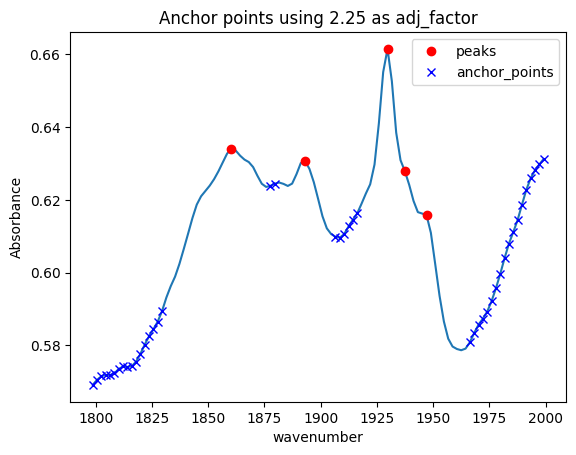

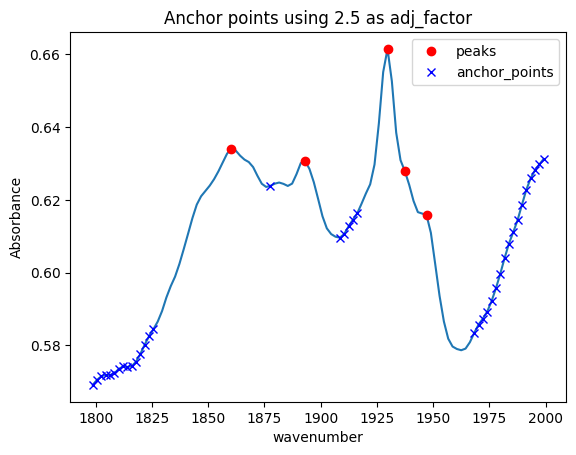

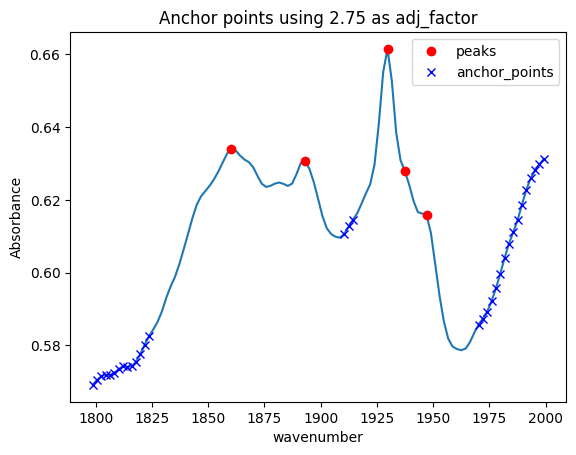

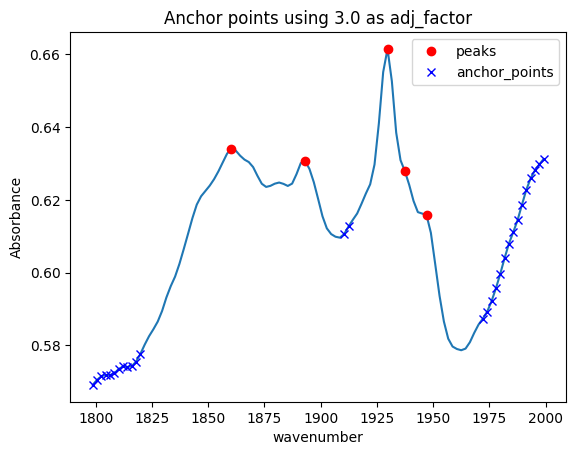

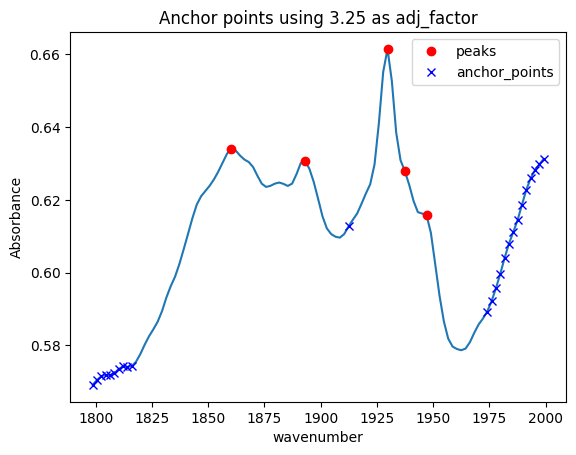

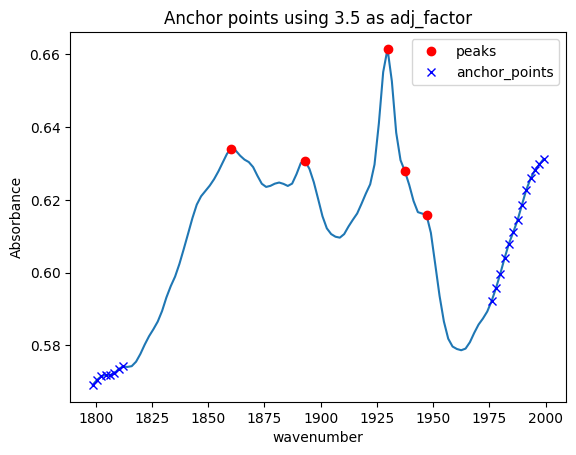

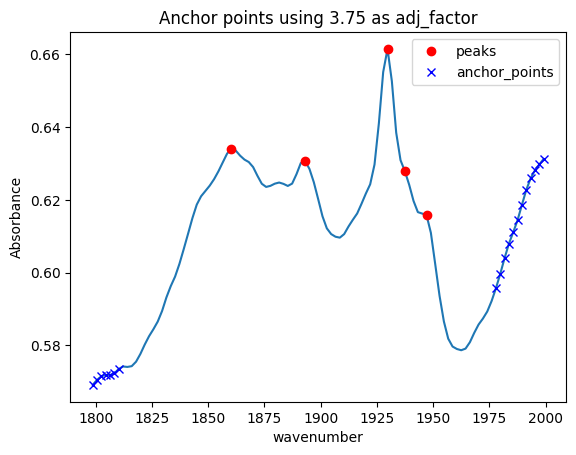

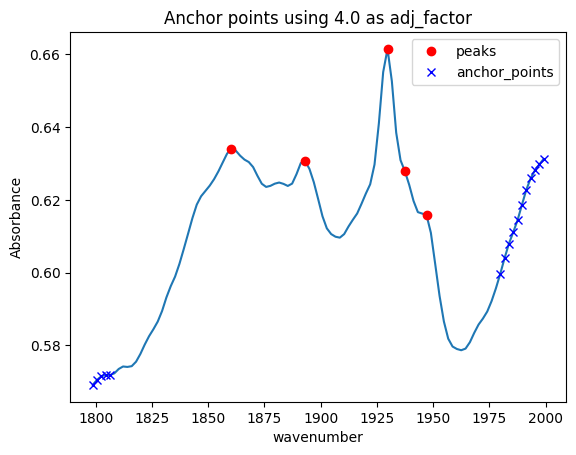

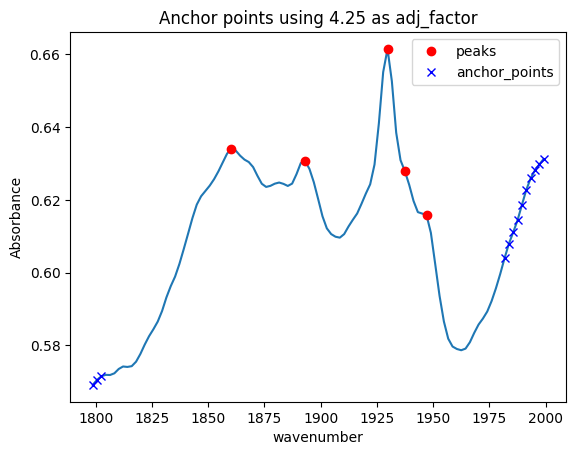

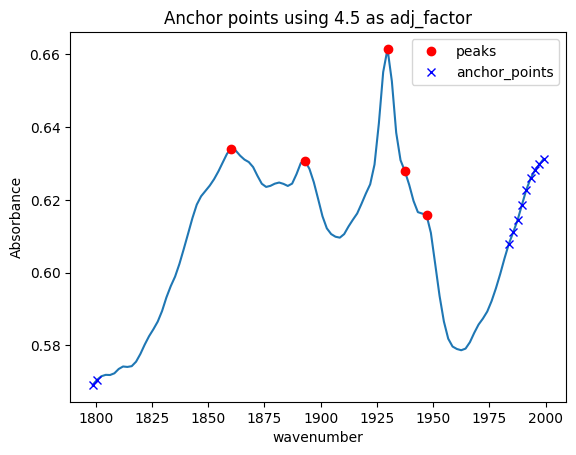

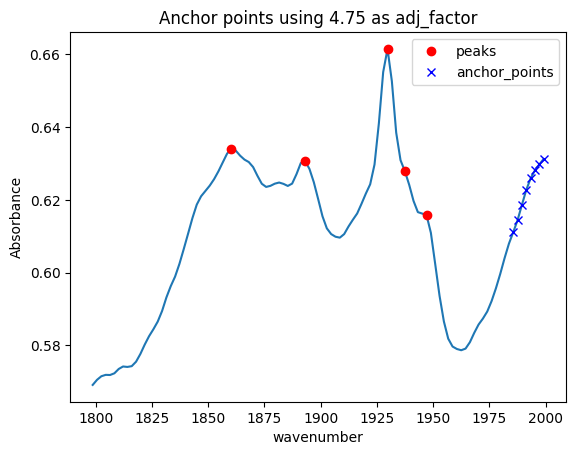

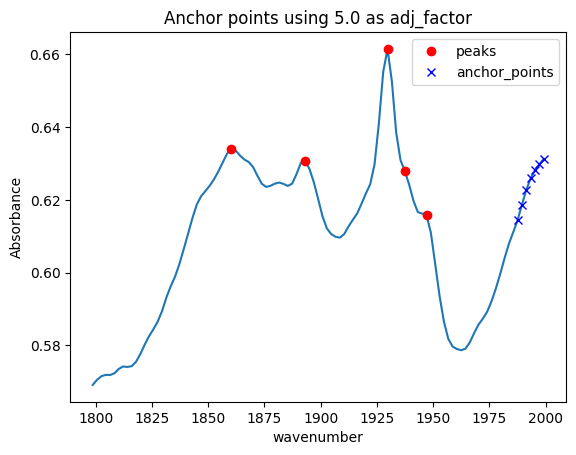

In [12]:
start = 1
end = 5
step = 0.25

adjustment_factor = np.arange(start, end + step, step)
#adjustment_factor = [1]
#using default prominence threshold of 15%
for adj_factor in adjustment_factor:
    plt.figure()
    peaks_index, deriv_x_peak_val = get_peaks(d2ydx2_spl_upsidedown,x)

    wv_startIdx, wv_endIdx, width_startIdx, width_endIdx = get_start_end_anchorpoints(peaks_index[0], d2ydx2_spl_upsidedown, x)
    y_corr_abs = example_cut_sub[0][0].sub_spectrum
    anchor_points_raw_data = example_cut_sub[0][0].wavenb
    get_all_anchor_points(wv_startIdx, wv_endIdx, deriv_x_peak_val, anchor_points_raw_data, y_corr_abs, f'Anchor points using {adj_factor} as adj_factor', adj_factor)